# ADVANCED REGRESSION ANALYSIS

In this notebook we will tune lambda parameters of both ridge & lasso regression to find the best lambda parameters. After tuning we try fitting 4 different models to find the best model in terms of r_square score; among those 4 models are the best ridge regression and lasso regression models we found by tuning. Finally we will close the notebook by investigating the most weigted +ve and -ve coefficients of the best ridge and lasso regression models.

**Add the directory of m_learn package to the system path**

In [1]:
from config import *
append_path('../../')

**Import necessary packages and modules**

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from m_learn.utility.data_preprocessing import train_test_feature_scaler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Load and inspect the data

In [3]:
data = pd.read_csv('./../../data/house_prices/train.csv')

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Drop the id since this is useless info**

In [5]:
data = data.drop('Id', axis=1)

In [6]:
# shape of the data
print("shape of data: ", data.shape)

shape of data:  (1460, 80)


## 2. Preprocess the data

### 2.1 Fill missing data and encoding categorical data

**Fill missing data with column mean**

In [7]:
data = data.fillna(data.mean())

**Encode categorical data**

In [8]:
data = pd.get_dummies(data)

In [9]:
print("shape of data: ", data.shape)

shape of data:  (1460, 289)


### 2.2 Feature Scale Train and Test Data

**Features and output**

In [10]:
# extract the features
features = data.columns.values.tolist()
# output of the model
output = 'SalePrice'
# remove the output from the list
features.remove(output)

**Train test split**

In [11]:
# import train test split module from scikit learn
from sklearn.model_selection import train_test_split
# carry out train test split in ratio 3:1
train_data, test_data = train_test_split(data, test_size = 0.25, random_state = 0)

**Scale train test data using min-max scaler**

In [12]:
# import the minmax scaler module from scikit learn
from sklearn.preprocessing import MinMaxScaler
# create a scalar object that scales data into a range of -1 to 1
scaler = MinMaxScaler((-1,1))
# scale the training and test set using the specialized scaling function we created earlier
train_data, test_data = train_test_feature_scaler(scaler, train_data, test_data, features)

**Display the scaled train and test data**

In [13]:
train_data.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,-0.411765,-0.732877,-0.950455,-0.111111,-0.25,-0.710145,-0.500000,-1.00000,-1.000000,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,107500
1,-0.294118,-0.664041,-0.911342,0.333333,0.00,0.724638,0.400000,-0.90500,-1.000000,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,160000
2,-0.294118,-0.664041,-0.916371,-0.333333,1.00,0.347826,0.700000,-1.00000,-0.426549,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,145000
3,-0.529412,-0.732877,-0.807147,-0.111111,0.00,0.927536,0.833333,-1.00000,-1.000000,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,192140
4,-1.000000,-0.609589,-0.917362,0.111111,0.25,0.478261,0.633333,-0.87625,-0.413274,-0.326786,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,181000
5,-0.529412,-0.424658,-0.884148,0.777778,0.00,0.942029,0.866667,-0.03500,-1.000000,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,380000
6,-0.647059,-0.787671,-0.958681,-0.111111,0.25,0.000000,-1.000000,-1.00000,-1.000000,-1.000000,...,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,66500
7,-0.176471,-0.732877,-0.941144,-0.111111,0.00,0.159420,-0.933333,-0.55000,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,124500
8,-1.000000,-0.657534,-0.926112,-0.111111,0.00,0.318841,-0.566667,-1.00000,-0.977876,0.557143,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,124000
9,-0.176471,-0.705479,-0.946912,0.111111,0.00,0.565217,0.000000,-1.00000,-0.065487,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,144000


In [14]:
test_data.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,-1.000000,-0.664041,-0.706766,0.111111,-0.50,0.231884,-0.166667,-0.870393,0.078761,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,200624
1,-0.647059,-0.602740,-0.923438,0.111111,0.50,0.000000,-1.000000,-1.000000,-0.643363,-0.705357,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,133000
2,-0.647059,-0.664041,-0.946575,-0.111111,-0.25,0.130435,-1.000000,-0.798750,-0.836283,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,110000
3,-0.529412,-0.575342,-0.918624,0.333333,0.00,0.521739,-0.100000,-0.626250,-0.653097,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,192000
4,0.647059,-1.000000,-0.996448,0.111111,0.00,0.434783,-0.300000,-0.523750,-1.000000,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,88000
5,-0.882353,-0.732877,-0.944846,-0.111111,-0.25,-0.449275,0.866667,-1.000000,-0.781416,-0.169643,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,85000
6,-1.000000,-0.808219,-0.869537,0.555556,0.00,0.956522,0.900000,-0.895000,-0.177876,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,282922
7,-0.647059,-0.801370,-0.928019,0.111111,0.25,-0.057971,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,141000
8,-0.529412,-0.047945,-0.866106,1.000000,0.00,0.797101,0.533333,-1.000000,0.854867,-1.000000,...,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,745000
9,0.647059,-0.664041,-0.964430,0.333333,0.00,0.913043,0.800000,-1.000000,-0.788496,-1.000000,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,148800


## 3. Tune ridge classifier

**Function to compute residual sum of square given model, X & y data**

In [15]:
def residual_sum_of_square(regression_model, X, y):

    '''
    A function which calculates the RSS of a fitted regression model given X y data
    Arguments:
    regression_model - a sklearn regression model
    X - feature matrix of shape (number of examples, number of features)
    y - vector of outputs of shape (number of examples,)
    Returns:
    rss - residual sum of square of the regression model
    '''

    # compute predictions vector
    predictions = regression_model.predict(X)
    # compute residual
    residual = y - predictions
    # compute square of residual
    residual_squared = residual*residual
    # compute sum of square of residual
    rss = residual_squared.sum()

    # return the rss
    return rss

**Function for tuning l2 penalty of ridge classifier**

In [16]:
def tune_ridge_classifier(l2_penalties, train_data, test_data, features, output):

    '''
    A function for tuning the l2 penalty value of ridge regression given train and test data
    Arguments:
    l2_penalties - list of l2 penalties (python list)
    train_data - pandas dataframe containing training set
    test_data - pandas dataframe containing test set
    features - list of features of the regression model (python list)
    output - output of the regression model (python string)
    Returns:
    RSS - list of residual sum of squares of the ridge models having different l2 penalties (python list)
    models - list of objects of the fitted ridge models (python list)
    '''

    # import scikit learn ridge regression model
    from sklearn.linear_model import Ridge

    # a list to store the residual sum of squares of the ridge models having different l2 penalties
    RSS = []
    # a list to store the model objects
    models = []

    # iterate through each penalty value
    for penalty in l2_penalties:
        # create a ridge regression model of given penalty
        model = Ridge(alpha = penalty)
        # fit the model
        model.fit(train_data[features], train_data[output])
        # append the model to the designated list
        models.append(model)
        # compute RSS using test data
        rss = residual_sum_of_square(model, test_data[features], test_data[output])
        # append the RSS to the designated list
        RSS.append(rss)

    # return the list of RSS & model objects
    return RSS, models

**Generate logspace of l2 penalty**

In [17]:
l2_penalties = np.logspace(0,3, num=100)

**Tune ridge classifier and extract RSS values and the model objects of the classifiers**

In [18]:
RSS_ridge, models = tune_ridge_classifier(l2_penalties, train_data, test_data, features, output)

/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packag

/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packag

**Plot of CV error vs L2 penalty**

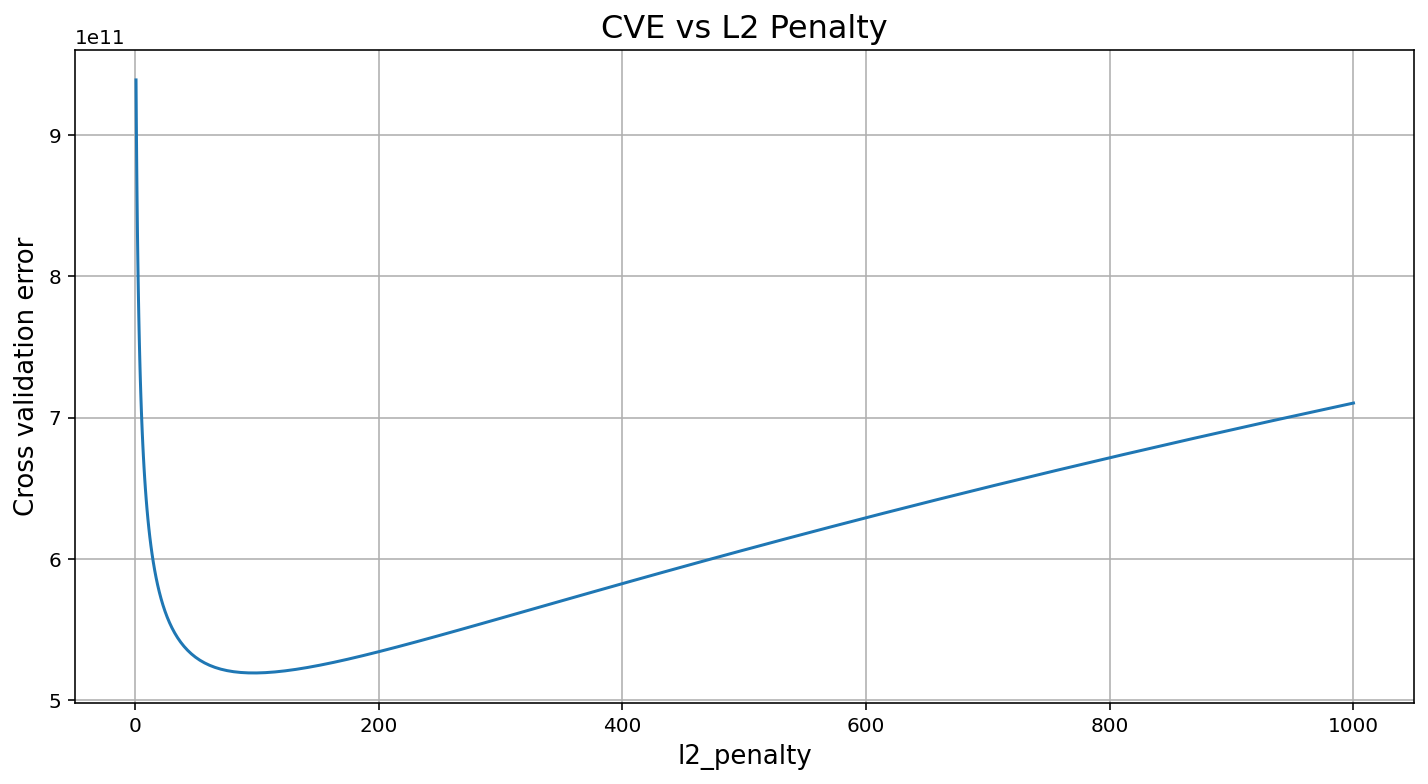

In [19]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(l2_penalties, RSS_ridge)
plt.xlabel("l2_penalty", fontsize = 13)
plt.ylabel("Cross validation error", fontsize = 13)
plt.title("CVE vs L2 Penalty", fontsize = 16)
plt.grid()

**Get the l2 penalty that yielded the minimum error**

In [20]:
min_penalty_ridge = l2_penalties[np.argmin(RSS_ridge)]
min_penalty_ridge

100.0

## 4. Tune lasso classifier

**Function for tuning l1 penalty of lasso classifier**

In [21]:
def tune_lasso_classifier(l1_penalties, train_data, test_data, features, output):

    '''
    A function for tuning the l1 penalty value of lasso regression given train and test data
    Arguments:
    l1_penalties - list of l1 penalties (python list)
    train_data - pandas dataframe containing training set
    test_data - pandas dataframe containing test set
    features - list of features of the regression model (python list)
    output - output of the regression model (python string)
    Returns:
    RSS - list of residual sum of squares of the lasso models having different l1 penalties (python list)
    models - list of objects of the fitted lasso models (python list)
    '''

    # import scikit learn ridge regression model
    from sklearn.linear_model import Lasso

    # a list to store the residual sum of square of the lasso models of different l1 penalties
    RSS = []
    # a list to store the model objects
    models = []

    # iterating through each penalty value
    for penalty in l1_penalties:
        # create a lasso regression model of given penalty
        model = Lasso(alpha = penalty, max_iter = 10000)
        # fit the model
        model.fit(train_data[features], train_data[output])
        # append the model to the designated list
        models.append(model)
        # compute RSS using test data
        rss = residual_sum_of_square(model, test_data[features], test_data[output])
        # append the RSS to the designated list
        RSS.append(rss)

    # return the list of RSS & model objects
    return RSS, models

**Create linspace of l1 penalties**

In [22]:
l1_penalties = np.linspace(1,6000,100)

**Tune lasso classifier and extract RSS values and the model objects of the classifiers**

In [23]:
RSS_lasso, models = tune_lasso_classifier(l1_penalties, train_data, test_data, features, output)

**Plot of CV error vs L1 penalty**

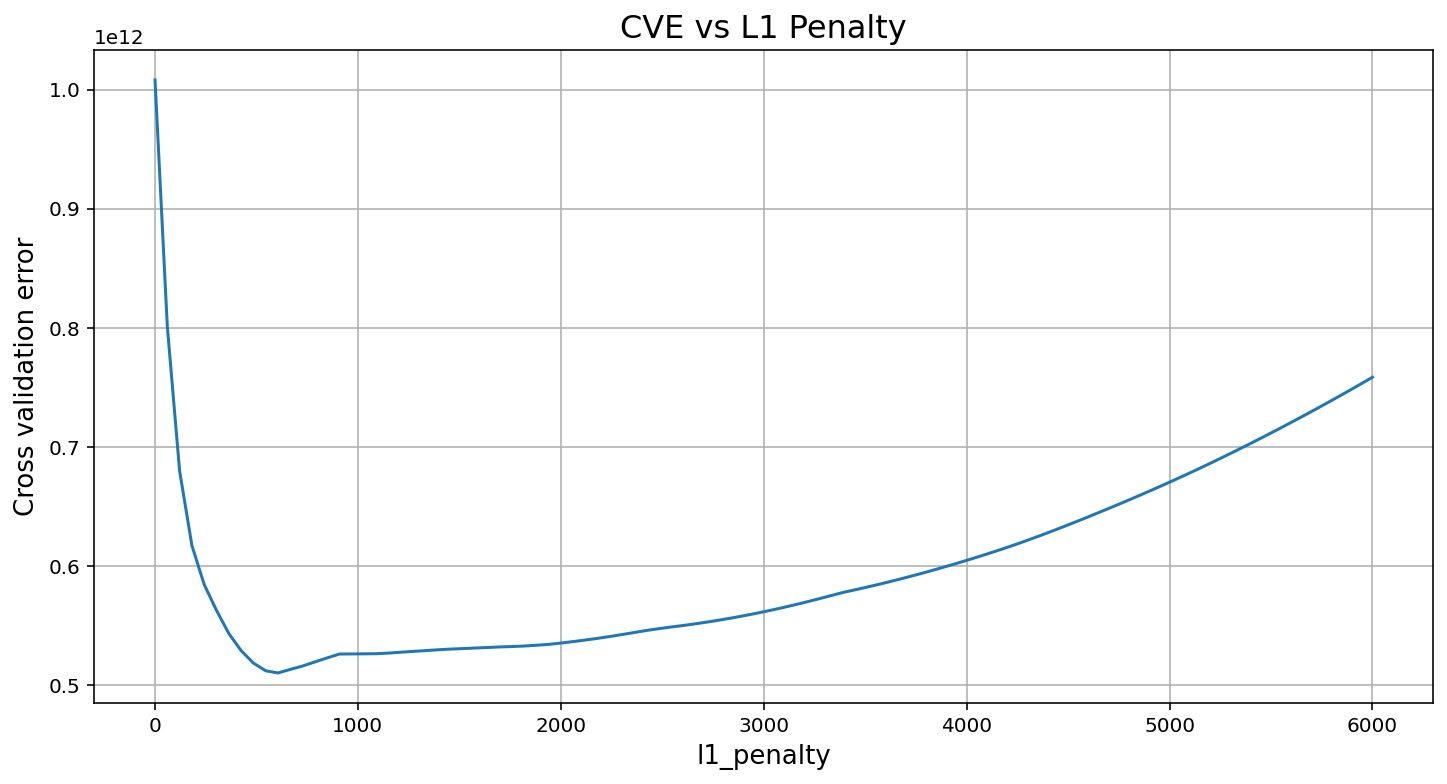

In [24]:
plt.plot(l1_penalties, RSS_lasso)
plt.xlabel("l1_penalty", fontsize = 13)
plt.ylabel("Cross validation error", fontsize = 13)
plt.title("CVE vs L1 Penalty", fontsize = 16)
plt.grid()

**Get the l1 penalty that yielded the minimum error**

In [25]:
index_min_lasso = np.argmin(RSS_lasso)
min_penalty_lasso = l1_penalties[index_min_lasso]
min_penalty_lasso

606.959595959596

**Examine the sparse coefficients of lasso model with the min error**

In [26]:
coeffs = models[index_min_lasso].coef_
coeffs 

array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.20880748e+04,
        6.45842310e+03,  0.00000000e+00,  5.15765582e+03,  4.83366223e+03,
        1.21683623e+04,  0.00000000e+00,  0.00000000e+00,  1.94710093e+04,
        1.69100617e+03,  0.00000000e+00, -0.00000000e+00,  8.92486269e+04,
        0.00000000e+00,  0.00000000e+00,  5.28743276e+03,  1.30248607e+03,
        0.00000000e+00, -0.00000000e+00,  1.74233302e+03,  9.86399343e+03,
        0.00000000e+00,  9.44682806e+03,  8.61635205e+03,  4.10926888e+03,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.96352502e+02, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  9.74248975e+02,
       -2.00909032e+03, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  2.58037378e+03,  0.00000000e+00,
       -1.45163989e+03, -8.73576298e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

**List of non zero coefficients**

In [27]:
boolean_array = coeffs != 0.0
features = data.columns[data.columns != 'SalePrice']
selected_features = features[boolean_array].tolist()
features = features.tolist()
features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'LandSlo

**Number of nonzero coefficients**

In [28]:
print("Number of nonzero coefficients:",len(selected_features))

Number of nonzero coefficients: 62


## 5. Examine the performance of different regression models

### 5.1 Create the model objects

In [29]:
# import the models from sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# create the model objects
linear_regression = LinearRegression()
linear_regression_selected_feat = LinearRegression()
ridge_regression = Ridge(min_penalty_ridge)
lasso_regression = Lasso(min_penalty_lasso)

### 5.2 Train the models using the train data

In [30]:
linear_regression.fit(train_data[features], train_data[output])
linear_regression_selected_feat.fit(train_data[selected_features], train_data[output])
ridge_regression.fit(train_data[features], train_data[output])
lasso_regression.fit(train_data[features], train_data[output])

/home/ssl/anaconda3/envs/mfr_api/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Lasso(alpha=606.959595959596)

### 5.3 Compute the R_Square score of the models using the test data

In [31]:
# import the r2 score function from sklearn
from sklearn.metrics import r2_score

# calculate the r2 score of the fitted models
linear_regression_score = r2_score(test_data[output], linear_regression.predict(test_data[features]))
linear_regression_selected_feat_score = r2_score(test_data[output], linear_regression_selected_feat.predict(test_data[selected_features]))
ridge_regression_score = r2_score(test_data[output], ridge_regression.predict(test_data[features]))
lasso_regression_score= r2_score(test_data[output], lasso_regression.predict(test_data[features]))

In [32]:
print("R_square Score of linear regression model (all features): ", linear_regression_score)
print("R_square Score of linear regression model (selected features): ", linear_regression_selected_feat_score)
print("R_square Score of ridge regression model : ", ridge_regression_score)
print("R_square Score of lasso regression model : ", lasso_regression_score)

R_square Score of linear regression model (all features):  -1.3913708933537841e+19
R_square Score of linear regression model (selected features):  0.7831574229562053
R_square Score of ridge regression model :  0.7844808155265024
R_square Score of lasso regression model :  0.788188128669483


### 5.4 Visualize the top 10 +ve and -ve coefficients of the tuned ridge model

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

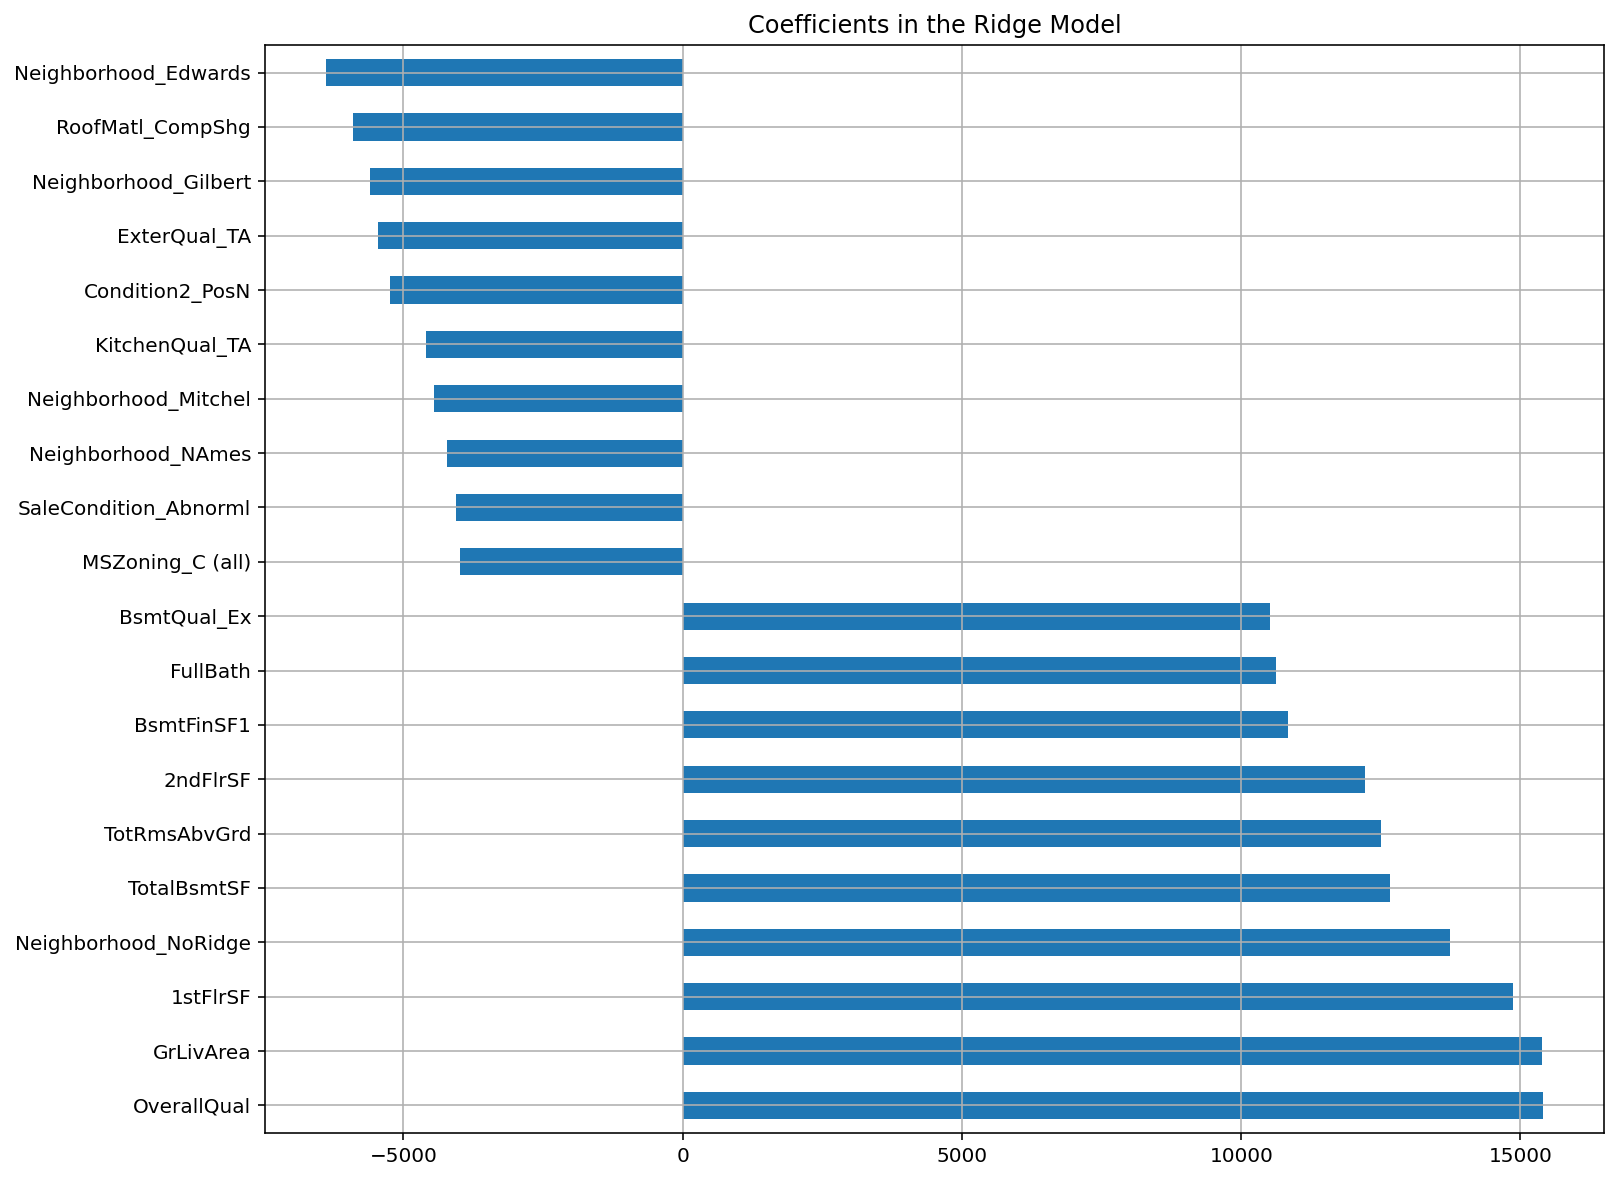

In [33]:
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)
# create a pandas series of the ridge coefficients with features as the data index
ridge_coeff = pd.Series(ridge_regression.coef_, index = features)
# sort the series by coefficients in descending order
ridge_coeff = ridge_coeff.sort_values(ascending = False)
# create another pandas series that contains the tail and the head of the above sorted series
ridge_coeff = pd.concat([ridge_coeff.head(10), ridge_coeff.tail(10)])
# plot horizontal bar chart of the head and tail of the coefficient list 
ridge_coeff.plot(kind = "barh", grid=True)
plt.title("Coefficients in the Ridge Model")

### 5.5 Visualize the top 10 +ve and -ve coefficients of the tuned lasso model

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

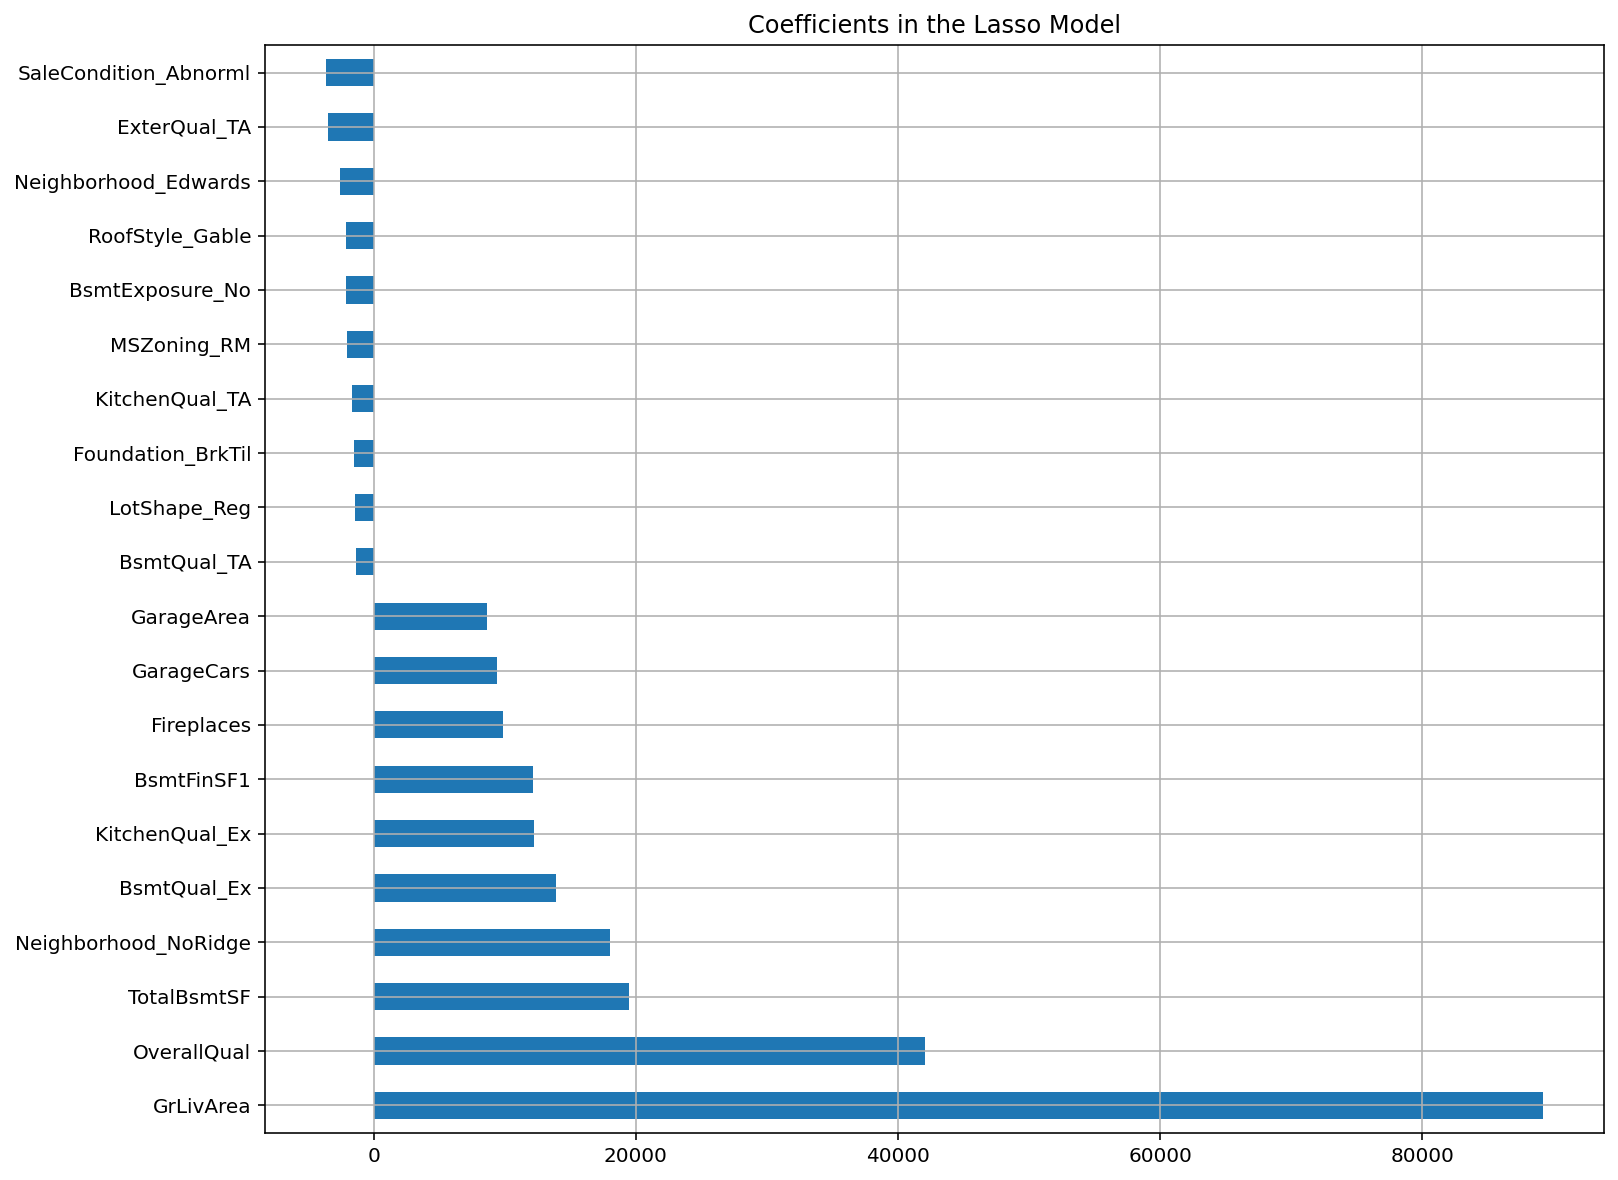

In [34]:
# create a pandas series of the lasso coefficients with features as the data index
lasso_coeff = pd.Series(lasso_regression.coef_, index = features)
# sort the series by coefficients in descending order
lasso_coeff = lasso_coeff.sort_values(ascending = False)
# create another pandas series that contains the tail and the head of the above sorted series
lasso_coeff = pd.concat([lasso_coeff.head(10), lasso_coeff.tail(10)])
# plot horizontal bar chart of the head and tail of the coefficient list 
lasso_coeff.plot(kind = "barh", grid=True)
plt.title("Coefficients in the Lasso Model")